In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import numpy as np
from tkinter import *
from PIL import Image, ImageTk, ImageDraw, ImageFont


import csv
import os

from app.core.PoseHelper import PoseHelper
from app.core.SugesstionBuilder import SuggestionBuilder
import time

In [2]:
poses = []
names = []
images = []

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False, min_detection_confidence=0.2, model_complexity=2
)

In [4]:
suggester = SuggestionBuilder()
window = Tk()

In [5]:
import os

print(os.getcwd())
for pose_name in os.listdir("app/data/suryanamaskarsteps/"):
        names.append(pose_name)
names.sort()
for i in range(len(names)):
        pose_dir_path = os.path.join("app/data/suryanamaskarsteps/", names[i])
        step = PoseHelper(pose_dir_path,mp_pose=mp_pose,pose=pose,mp_drawing=mp_drawing)
        step.detect_keypoints(verbose=False)
        step.calculate_angles()
        poses.append(step)
        
        img = Image.open(pose_dir_path)
        w,h = img.size
        

        # Create an ImageDraw object
        draw = ImageDraw.Draw(img)

        # Define text properties
        org = (5, 20)  # Bottom-left corner coordinates
        font = ImageFont.truetype('arial.ttf', 24)  # Specify font type and size
        color = (255, 0, 0)  # Red color
        thickness = 2

        # Add the text to the image
        draw.text(org, names[i], font=font, fill=color)

        img = ImageTk.PhotoImage(img.resize((500,int(h*500/w))))
        images.append(img)#)cv2.imread(pose_dir_path))
        
print(names)

c:\Users\megha\Downloads\YogaPoseHelper-main (3)\YogaPoseHelper-main
['00.pranamasana_new_side_view.png', '00.pranamasana_side_view.jpeg', '01.pranamasana.jpg', '02.hastauttasana.jpg', '03.padasana.jpg', '04.ashwasanchalanasana.jpg', '05.chaturangadandasana.jpg', '06.astanganamaskara.jpg', '07.bhujangasana.jpg', '08.parvatasana.jpg', '09.ashwasanchalanasana.jpg', '10.padasana.jpg', '11.hastauttasana.jpg', '12.pranamasana.jpg']


In [6]:
step = PoseHelper("app/media/raised_arms_side_view.jpeg")  # app/media/00.goddess.jpg")
step.detect_keypoints(verbose=False)
step.calculate_angles()

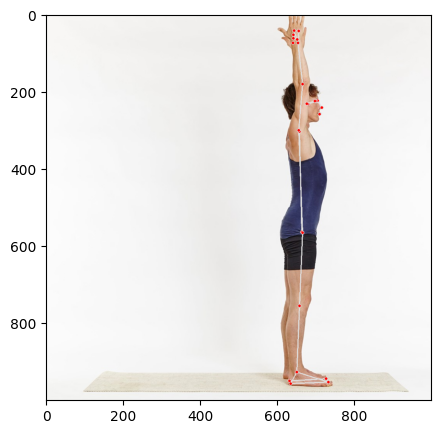

In [7]:
pose_index = 0 # next pose index
ideal = step # poses[pose_index]
ideal_arms_and_angles = ideal.arms_and_angles
pose_name = "goddess" # names[pose_index]
ideal.plot_keypoints2d()

In [8]:

window.title("Pose Helper")
window.state('zoomed')

#text box
ideal_title_text_label = Label(window,text="Ideal Pose",font=("Arial",30),bg="white")
ideal_title_text_label.grid(column=0,row=0, sticky="nsew")

text_label2 = Label(window,text="Live Video",font=("Arial",30),bg="white")
text_label2.grid(column=1,row=0, sticky="nsew")

#img_label_frame=Frame(window,height=200,width=200)
img_label = Label(window,image=images[0],width=200,height=200)
img_label.grid(row=1,column=0, sticky="nsew")

live_video_label = Label(window,image=images[0],width=200,height=300)
live_video_label.grid(row=1,column=1, sticky="nsew")



# create a frame with fixed size
frame = Frame(window, height=200, width=900)
frame.pack_propagate(0) # don't shrink or expand
frame.grid(row=2, column=0, columnspan=2)

suggestions_label = Label(frame,text="suggestions\n1\n2",anchor='n',bg='white',font=("Arial",20))
suggestions_label.pack(fill=BOTH, expand=1) # fill the frame



window.grid_rowconfigure(0, weight=1)
window.grid_rowconfigure(1, weight=1)
window.grid_columnconfigure(0, weight=1)
window.grid_columnconfigure(1, weight=1)

In [9]:
# TODO - make seperate thread for tts so it doesn't block main execution
# import pyttsx3

# def speak_text(text: str):
#     engine = pyttsx3.init()
#     engine.say(text)
#     engine.runAndWait()
#     return engine


In [10]:
cap = cv2.VideoCapture(0)

In [11]:
quit = False
def quit_func(*args):
    global quit
    quit = True
    print("quitting")
    cap.release()
    window.destroy()
window.bind("q",quit_func)
window.protocol("WM_DELETE_WINDOW",quit_func)

''

In [12]:
from app.core.graphics.graphics_assistant import draw_error_landmarks_2d


n = len(poses)
start_time = time.time() - 6
print(start_time)
pose_index = -1


def update_live():
    global quit, start_time, pose_index, poses, n, images, names, ideal_arms_and_angles, live_video_label, cap, pose_name, img_label
    if cap.isOpened():
        success, frame = cap.read()
        # print(success)
        end_time = time.time()
        if end_time - start_time >= 6:
            pose_index += 1
            start_time = end_time
            ideal = poses[pose_index % n]
            ideal_arms_and_angles = ideal.arms_and_angles
            pose_name = names[pose_index % n]

            img_label.configure(image=images[pose_index % n])
            img_label.image = images[pose_index % n]

        # playsound("app/media/sound/beep.mp3")
        # engine = speak_text(pose_name.split(".")[1])

        if success:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame)

            if results.pose_landmarks:
                helper = PoseHelper(
                    img=frame, mp_pose=mp_pose, pose=pose, mp_drawing=mp_drawing
                )
                helper.detect_keypoints(verbose=False)
                helper.calculate_angles()
                arms_and_angles = helper.arms_and_angles
                n = 33  # len(arms_and_angles)
                arms_and_angles_diff = PoseHelper.calculate_angle_differences(
                    ideal_arms_and_angles, arms_and_angles, n
                )
                # il,rl =  list(ideal_arms_and_angles[11].values())[0],list(arms_and_angles[11].values())[0]
                # suggestion_text = f"""
                # left shoulder: {il} {np.linalg.norm(il)}
                # {rl} {np.linalg.norm(rl)}
                # {il-rl} {np.linalg.norm(il-rl)}"""  #
                suggestion_texts = suggester.get_suggestions(arms_and_angles_diff)
                suggestion_texts.sort(key=lambda x: x[1], reverse=True)
                suggestions_label.configure(
                    text="\n".join([f"{s[0]}" for s in suggestion_texts])
                )

                # draw the landmarks

                draw_error_landmarks_2d(
                    arms_and_angles_diff=arms_and_angles_diff,
                    img=frame,
                    landmark_list=results.pose_landmarks,
                    pronounce_error_by=3,
                    connections=mp_pose.POSE_CONNECTIONS,
                    verbose=False,
                )

            # convert back to bgr
            # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            # put the pose name on the image
            cv2.putText(
                frame, pose_name, (5, 20), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2
            )

            live_img = ImageTk.PhotoImage(Image.fromarray(frame))
            live_video_label.configure(image=live_img)
            live_video_label.image = live_img

    window.update()  # to refresh the window

    window.after(
        10, update_live
    )  # to add our custom update function to the queue to be executed


update_live()
window.mainloop()

1703698708.6303182
quitting
